## Kaggle: NOAA Fisheries Steller Sea Lion Population Count

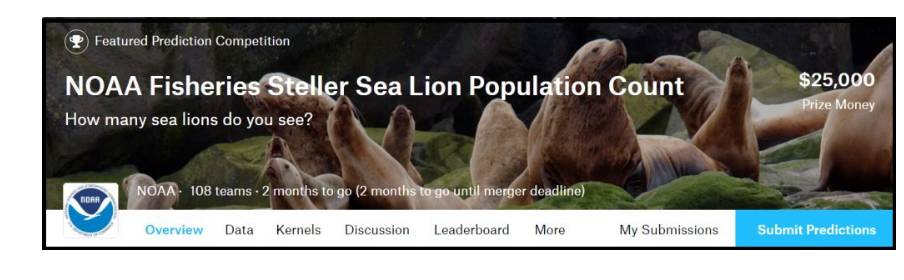

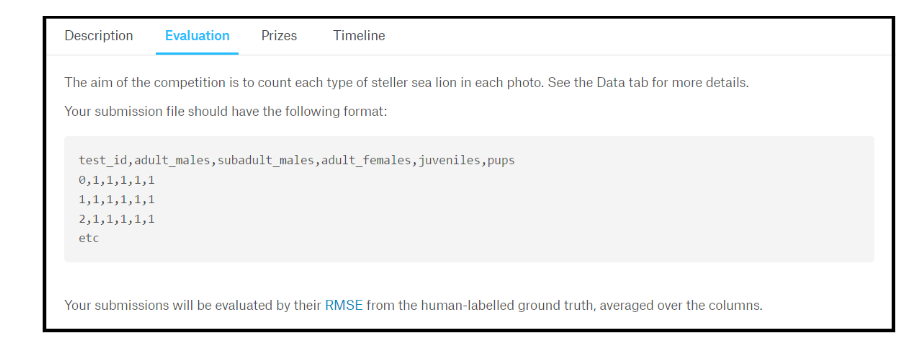

In [2]:
import helper_files as hf
if (1): hf.show_banner()

## Data Files  
* **KaggleNOAASeaLions.7z ==> Large Dataset (95.83 GB)**
* **TrainSmall2.7z ==> Small Dataset (98.62 MB)**     


* **Test/*.jpg: (18,636) Test Images**
* **Train/*.jpg: (948) Training Images**
* **TrainDotted/*.jpg:** <span style="color:red">**Color Dots**</span> **show location of Sea Lion on Training Images**


* **mismatched.csv: some training images do not match their equivalents in TrainDotted**
* **Train/train.csv: image list (train_id) and ground-truth counts for each aerial photograph**

## Categories of Sea Lion
* <span style="color:red">**Red: Adult Males**</span>   
* <span style="color:magenta">**Magenta: Subadult Males**</span>  
* <span style="color:brown">**Brown: Adult Females**</span>
* <span style="color:blue">**Blue: Subadult Females**</span>
* <span style="color:green">**Green: Pups Males / Females**</span>

## Introduction

**Steller sea lions in the western Aleutian Islands have declined 94 percent in the last 30 years. The endangered western population, found in the North Pacific, are the focus of conservation efforts which require annual population counts. Currently, it takes biologists up to four months to count sea lions from the thousands of aerial photographs NOAA Fisheries collects each year. The objective of this competition is to develop an algorithm that automates the counting and classification of sea lions from over 18,000 aerial photographs (100 GB) taken each year.**

## Solution Approach
**This project is very similar to the Traffic Sign Classifier (CarND P2) and Vehicle Detection (CarND P5) projects. Instead of classifying traffic signs, we are classifying and counting different types of Sea Lions. The first part of the project detects the locations of sea lions from training images. These coordinates are then used to extract sample images of sea lions to train the deep learning models. The NVIDIA Deep Learning Model Architecture is then used as a proof of concept to verify the quality of the training data for classification (similar to the Traffic Sign Classifier).**

### Method #1: Sliding Windows with NVIDIA Model Architecture

**This project is also similar to Vehicle Detection where Sliding Windows were used to create heatmaps for detecting and tracking vehicles. Sliding Windows could be used to detect, classify and count Sea Lions, but these images are very large and this approach is not feasible. Let's assume the average test image is (5000 x 4000) and the sliding windows are (100 x 100). This would create 2000 windows to analyze (without any overlap). If we generously say that the AWS GPU (g2.2xlarge) instances can process one Test Image per second, that would require 5 hours of GPU time for the entire test set!**

**The project code shows that test image quality is still very high even with 50% compression in each direction. This reduces file size for the test set from 100 GB to 30 GB, which will greatly speed analysis. Howeever, Sliding Windows is still a brute force approach and we definitely need to find a more efficient solution.**

### Method #2: Darknet-19 Model Architecture (YOLO v2)

**Darknet (YOLO v2) is an extension of the original YOLO (You Only Look Once) model architecture. This recent model (Dec 2016) has similar accuracy to SSD and Faster R-CNN, but at much faster fps. The Darknet model architecture should be the perfect deep learning network for counting and classifying different types of sea lions.**

## Project Overview

* **Load Libraries**
* **Dataset Summary**
* **Exploratory Visualization**


* **Preprocess Data: 1st phase**
  * **Get Blob Coordinates --> Locate Color Dots on TrainDotted pics**  
  * **RGB Color Distribution for Color Dots --> Use results to train GaussianNB for better accuracy**
  * **Display Sample Images of Sea Lions found on Train pics with coordinates from TrainDotted pics**  


* **Preprocess Data: 2nd phase** 
  * **Get Blob Coordinates (GaussianNB) --> Locate Color Dots on TrainDotted pics** 
  * **Compress Test Images --> 100 GB to 30 GB**
  * **Extract Training Data from Training Images**


* **Model Training**
  * **Stratified Random Sampling --> Getting Random and Balanced Samples**
  * **Augmenting Dataset --> Flip Left / Right, Flip Up / Down, Rotate 90 degrees**
  * **Augmenting Dataset (additional possibilities) --> HSV, YUV, GRY, HLS, YCrCb**
  

* **Deep Learning**
  * **Method #1: Sliding Windows with NVIDIA Model Architecture (Brute Force)**
  * **Method #2: Darknet-19 (YOLO v2)**

## Deep Learning Reference

 
https://arxiv.org/pdf/1506.02640.pdf  
https://arxiv.org/pdf/1612.08242.pdf  

https://pjreddie.com/darknet/   
http://guanghan.info/blog/en/my-works/train-yolo/  


## Deep Learning: Darknet-19 Model Architecture (YOLO v2)

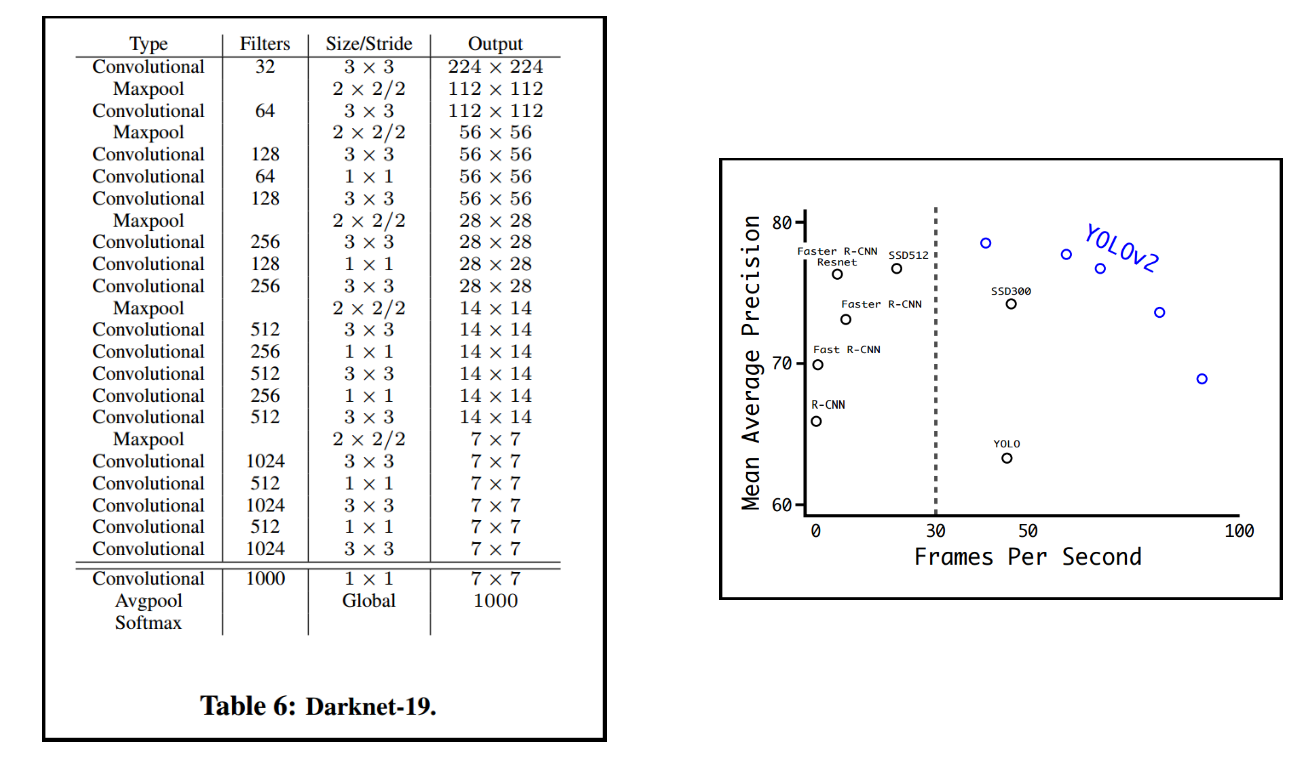

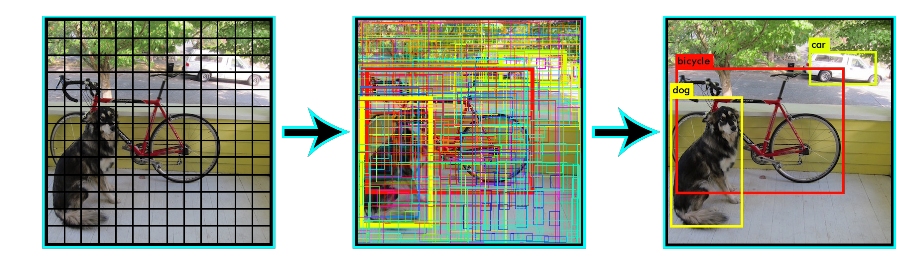

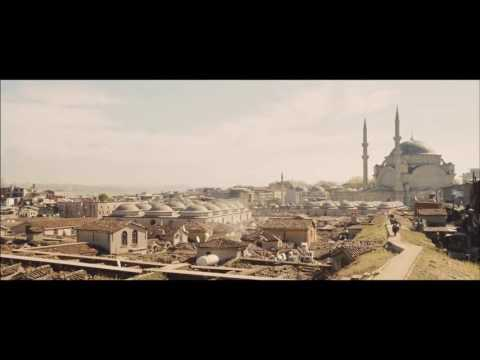

In [3]:
if (1): hf.show_yolo()    
from IPython.display import YouTubeVideo
YouTubeVideo('VOC3huqHrss', width=975, height=425)

## Load Libraries

In [4]:
import cv2
import time 
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, MaxPooling2D, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, Nadam
from sklearn.model_selection import train_test_split
from skimage.feature import blob_log
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from keras.utils import np_utils
from sklearn.naive_bayes import GaussianNB
from IPython.display import YouTubeVideo
import helper_files as hf

%matplotlib inline

import sys
print(sys.version)
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)
import keras
print('Keras Version:',keras.__version__)

Using TensorFlow backend.


3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0
Keras Version: 2.0.2


## Dataset Summary
* **There is a strong correlation (0.80) between red (males), females (brown) and pups (green).**
* **The correlation between magenta (young males) and blue (young females) is very low wtih all categories.**

In [5]:
# loading list of mismatched training images
df_skip = pd.read_csv('./mismatched.csv') 

# loading ground truth sea lion counts for training images
df = pd.read_csv('./input/train/train.csv')
df = df.drop('train_id',1)

# using colors to refer to sea lion categories
df.columns = ['red', 'magenta', 'brown', 'blue', 'green']
df.describe()

red     magenta       brown        blue       green
count  948.000000  948.000000  948.000000  948.000000  948.000000
mean     5.687764    4.583333   39.595992   21.221519   17.178270
std      7.582533    6.417079   67.711562   41.627674   48.111922
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      1.000000    1.000000    1.000000    1.000000    0.000000
50%      3.000000    3.000000   16.000000    8.000000    0.000000
75%      7.000000    6.000000   45.000000   26.000000    5.250000
max     64.000000   55.000000  682.000000  636.000000  529.000000

In [6]:
classes = hf.get_correl(df)


Correlation between each Category of Sea Lion:

[[ 1.          0.31959709  0.80142228  0.12761381  0.80508733]
 [ 0.31959709  1.          0.17258963  0.16083906  0.13347049]
 [ 0.80142228  0.17258963  1.          0.26813691  0.81557515]
 [ 0.12761381  0.16083906  0.26813691  1.          0.00674328]
 [ 0.80508733  0.13347049  0.81557515  0.00674328  1.        ]] 



## Exploratory Visualization

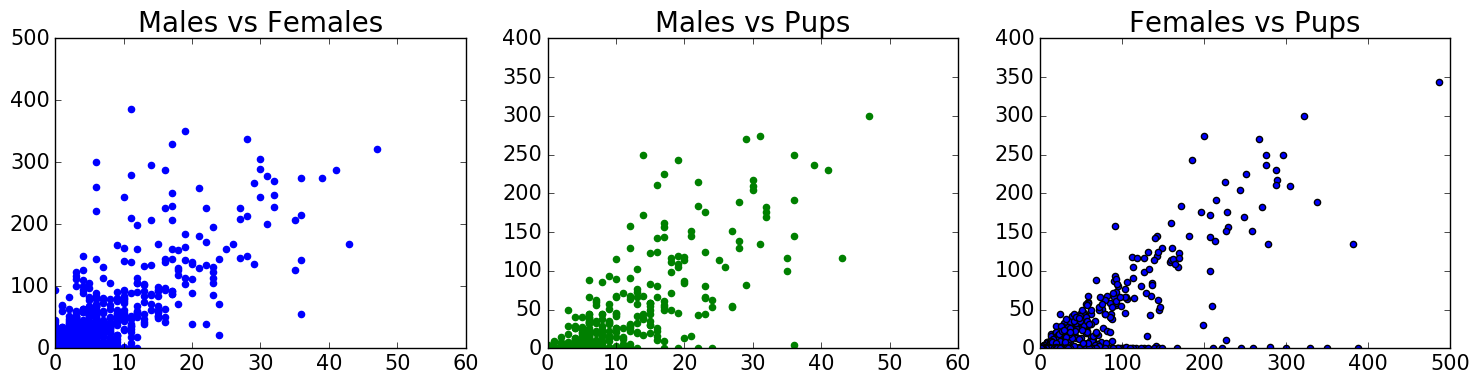

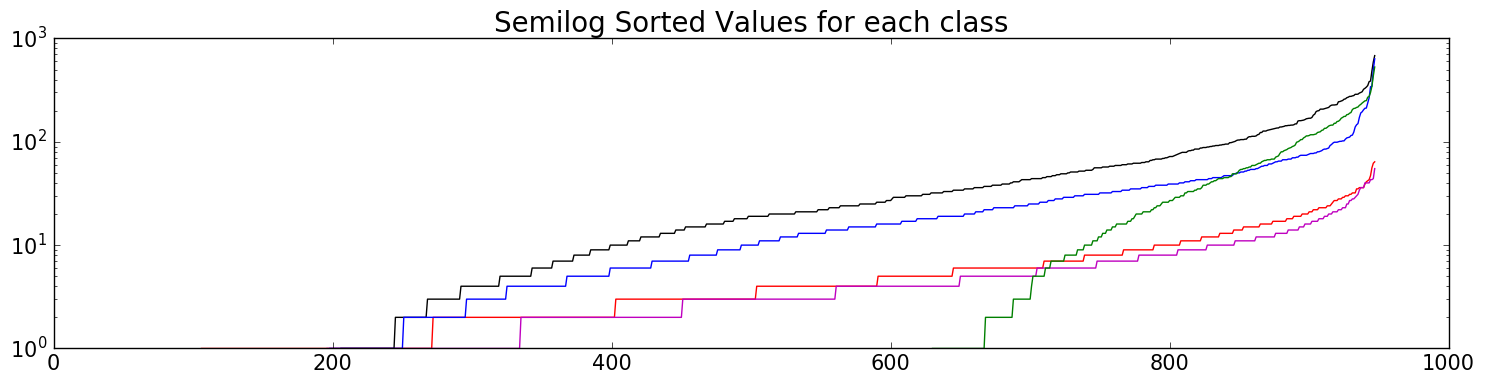

In [7]:
if (1): hf.plot_visuals(classes)

## Preprocess Data: 1st Phase: Get Blob Coordinates (Locate Color Dots)

In [8]:
def get_blob_coord(train_img):
    t = time.time()
    print ('Getting Color Blobs...')
    colors = ['red','magenta','brown','blue','green','error']
    df_blob = pd.DataFrame(index=df.index, columns=colors)

    count = 0
    R, G, B, color = [], [], [], []
    for fname in range(train_img[0],train_img[1]):
        count += 1
        if fname in list(df_skip['train_id']): continue
            
        img_1 = mpimg.imread('./input/Train/' + str(fname) + '.jpg')
        img_2 = mpimg.imread('./input/TrainDotted/' + str(fname) + '.jpg')
        img_3 = cv2.absdiff(img_2,img_1)
    
        mask_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
        mask_2[mask_2 < 20] = 0
        mask_2[mask_2 > 0] = 255

        img_4 = cv2.bitwise_or(img_3, img_3, mask=mask_2)
        img_5 = cv2.cvtColor(img_4, cv2.COLOR_RGB2GRAY)

        blobs = blob_log(img_5, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
        red, magenta, green, blue, brown, error = [], [], [], [], [], []
        
        #cut = np.copy(img_2)
        for blob in blobs:
            y, x, s = blob
            r,g,b = img_2[int(y)][int(x)][:]
        
            pred = predict_color(r,g,b)
            
            if pred[0] == 'red':
                red.append((int(y),int(x)))
                color.append('red')
            elif pred[0] == 'magenta':
                magenta.append((int(y),int(x)))
                color.append('magenta')
            elif pred[0] == 'brown':
                brown.append((int(y),int(x)))
                color.append('brown')
            elif pred[0] == 'blue':
                blue.append((int(y),int(x)))
                color.append('blue')
            elif pred[0] == 'green':
                green.append((int(y),int(x)))
                color.append('green')
            else:
                error.append((int(y),int(x)))
                color.append('error')
                
            R.append(int(r))
            G.append(int(g))
            B.append(int(b))
            #cv2.rectangle(cut, (int(x)-32,int(y)-32),(int(x)+32,int(y)+32), 0,-1)
        
        if count % 25 == 0:
            print ('File progress:',fname,len(red),len(magenta),len(brown),len(blue),len(green),len(error))
            
        df_blob.loc[fname,'red'] = red
        df_blob.loc[fname,'magenta'] = magenta
        df_blob.loc[fname,'brown'] = brown
        df_blob.loc[fname,'blue'] = blue
        df_blob.loc[fname,'green'] = green
        df_blob.loc[fname,'error'] = error
    
    df_color = pd.DataFrame({'R':R, 'G':G, 'B':B,'color':color})
    hf.check_colors(df,df_color,train_img)
    print ('\nTotal Training Images:',train_img[1]-train_img[0])
    print ('Time for getting Sea Lion coordinates:', np.round(time.time() - t, 4),'\n')
    return R,G,B,color,df_color,df_blob

In [9]:
def predict_color(r,g,b):   
    if r > 200 and g < 50 and b < 50: pred = ('red',)
    elif r > 200 and g < 50 and b > 200: pred = ('magenta',)
    elif r < 100 and 150 < g < 200 and b < 100: pred = ('green',)
    elif r < 100 and g < 100 and b > 100: pred = ('blue',)
    elif r < 150 and g < 100 and b < 50: pred = ('brown',)
    else: pred = ('error',)
    return pred
   
if (1):
    # getting locations of sea lions (color dots) in TrainDotted/*.jpg
    # coordinates will be used to extract sea lion pics from Train/*.jpg
    train_img = (41,51) # (0,947)
    R,G,B,color,df_color,df_blob = get_blob_coord(train_img)
    pickle.dump(df_color,open('df_color.p','wb'))
    pickle.dump(df_blob,open('df_blob.p','wb'))
       
df_color = pickle.load(open('df_color.p','rb'))
df_blob = pickle.load(open('df_blob.p','rb')) 
df_blob[43:47]

Getting Color Blobs...

colors: red, magenta, brown, blue, green

color_true:  [77, 47, 676, 150, 281]
color_found: [78, 45, 676, 150, 281]
color_diff:  [-1, 2, 0, 0, 0] 

color accuracy: [99.0, 96.0, 100.0, 100.0, 100.0]

Total Training Images: 10
Time for getting Sea Lion coordinates: 48.4272 



red  \
43  [(1003, 2725), (1059, 2528), (1288, 2258), (13...   
44         [(1494, 3068), (1867, 3599), (2145, 3360)]   
45  [(1068, 2519), (1423, 2546), (2048, 2108), (31...   
46                                     [(1338, 5418)]   

                                              magenta  \
43  [(1034, 2708), (2212, 1817), (3125, 3801), (35...   
44                       [(1240, 2950), (1740, 3375)]   
45  [(1267, 2696), (1312, 2663), (1419, 2684), (14...   
46  [(1328, 5492), (1432, 5569), (1485, 5600), (20...   

                                                brown  \
43  [(1036, 2807), (1090, 2809), (1171, 2785), (11...   
44  [(1727, 3458), (1777, 3384), (1838, 3393), (19...   
45  [(1021, 2691), (1035, 2580), (1035, 2616), (10...   
46                                                 []   

                                                 blue  \
43  [(952, 2273), (1007, 2678), (1021, 2599), (102...   
44  [(1472, 3131), (1488, 3137), (1750, 3449), (18...   
45  [(1011, 2589), (1020, 2624), (1055, 2673), (10...   
46                                                 []   

                                                green  \
43  [(1364, 2563), (1480, 2611), (1503, 2349), (15...   
44                                                 []   
45                                                 []   
46                                                 []   

                                                error  
43                                                 []  
44                                                 []  
45                                                 []  
46  [(756, 2300), (1149, 2543), (1389, 2575), (196...

## Preprocess Data: 1st Phase: RGB Color Distribution for Color Dots

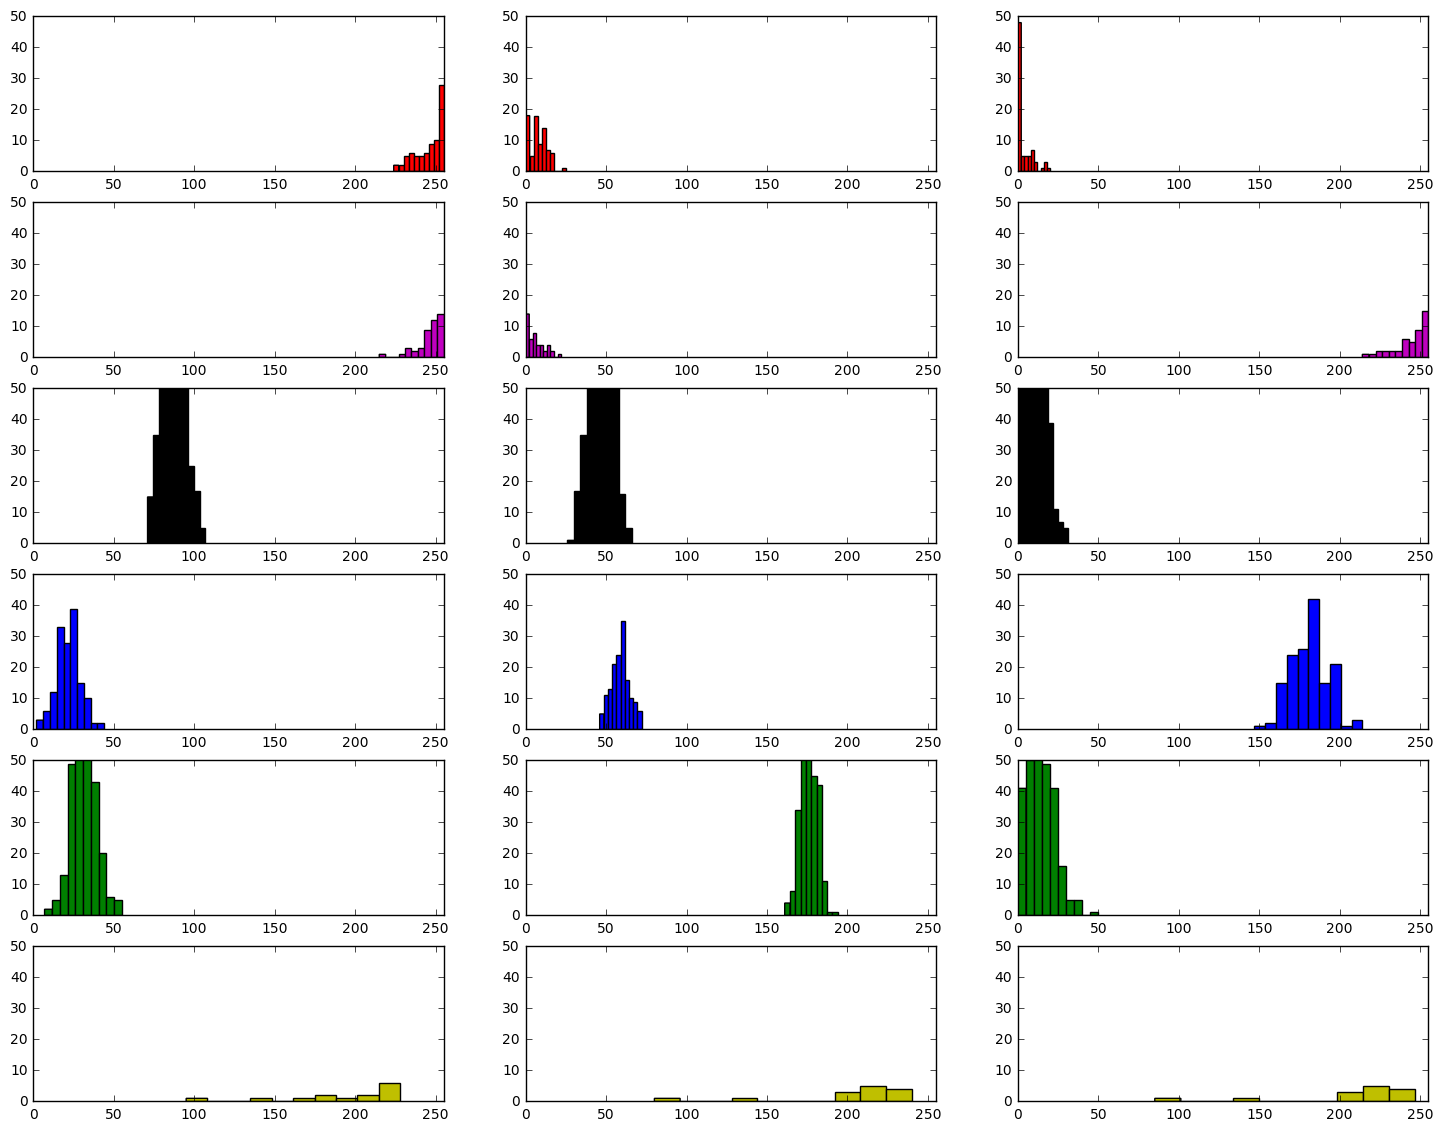

In [10]:
if (1): hf.plot_rgb_colors(df_color)

## Preprocess Data: 1st Phase: Display Sample Images
### Plot Sample Images for each class of Sea Lion
* **Red, Magenta, Brown are easiest to detect based on physical size (in that order)**
* **Blue is very difficult, Green looks almost impossible (the pups look like rocks!)**

### What are the Errors?
* **From the plots above (yellow distribution), it looks like the blob is detecting "white blobs" in the ocean**
* **The sample images below confirm that the "yellow" errors detected above are white caps in the ocean**

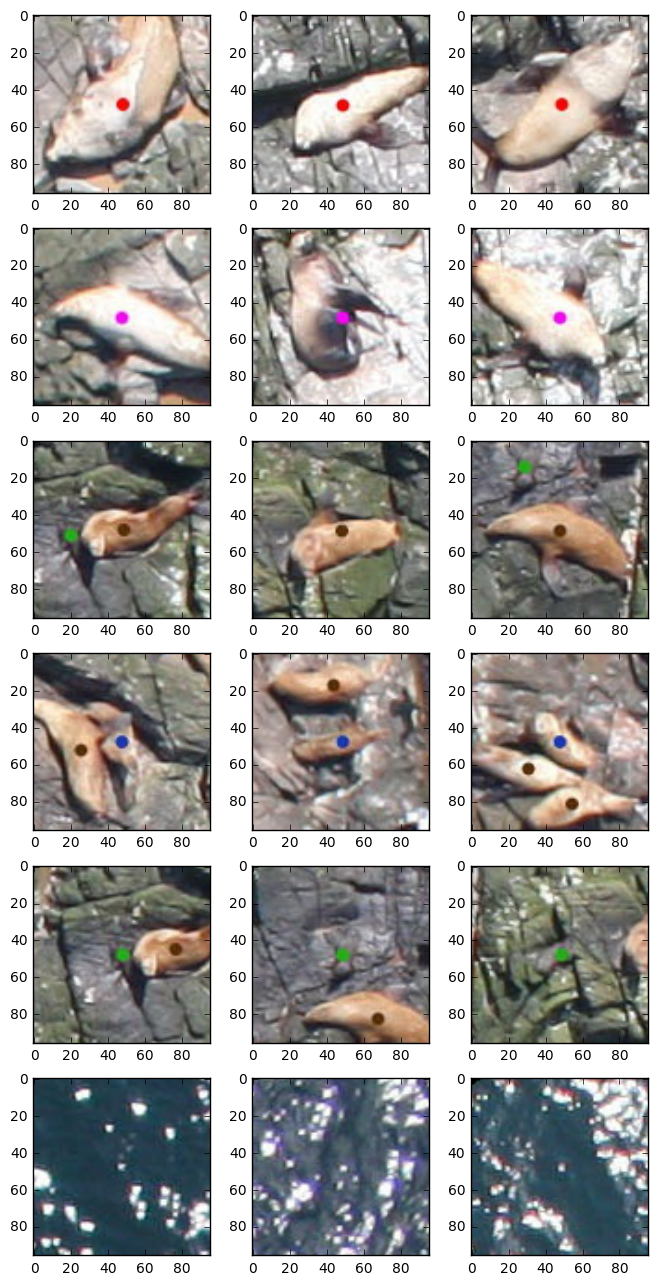

In [11]:
if (1): hf.plot_sample_images(df_blob)

## Preprocess Data: 2nd Phase: Get Blob Coordinates (GaussianNB)
* **Let's get better at identifying colors for blob detection and Sea Lion identification**
* **We are not changing blob detection, but optimizing the colors used for classification with the GaussianNB**

Plotting Learning Curve...
1.06 Seconds to Plot Learning Curve...
Done!


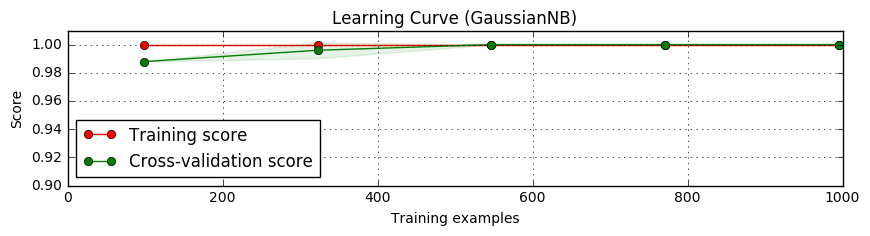

Getting Color Blobs...

colors: red, magenta, brown, blue, green

color_true:  [77, 47, 676, 150, 281]
color_found: [78, 45, 676, 150, 281]
color_diff:  [-1, 2, 0, 0, 0] 

color accuracy: [99.0, 96.0, 100.0, 100.0, 100.0]

Total Training Images: 10
Time for getting Sea Lion coordinates: 48.4368 



red  \
43  [(1003, 2725), (1059, 2528), (1288, 2258), (13...   
44         [(1494, 3068), (1867, 3599), (2145, 3360)]   
45  [(1068, 2519), (1423, 2546), (2048, 2108), (31...   
46                                     [(1338, 5418)]   

                                              magenta  \
43  [(1034, 2708), (2212, 1817), (3125, 3801), (35...   
44                       [(1240, 2950), (1740, 3375)]   
45  [(1267, 2696), (1312, 2663), (1419, 2684), (14...   
46  [(1328, 5492), (1432, 5569), (1485, 5600), (20...   

                                                brown  \
43  [(1036, 2807), (1090, 2809), (1171, 2785), (11...   
44  [(1727, 3458), (1777, 3384), (1838, 3393), (19...   
45  [(1021, 2691), (1035, 2580), (1035, 2616), (10...   
46                                                 []   

                                                 blue  \
43  [(952, 2273), (1007, 2678), (1021, 2599), (102...   
44  [(1472, 3131), (1488, 3137), (1750, 3449), (18...   
45  [(1011, 2589), (1020, 2624), (1055, 2673), (10...   
46                                                 []   

                                                green  \
43  [(1364, 2563), (1480, 2611), (1503, 2349), (15...   
44                                                 []   
45                                                 []   
46                                                 []   

                                                error  
43                                                 []  
44                                                 []  
45                                                 []  
46  [(756, 2300), (1149, 2543), (1389, 2575), (196...

In [12]:
def get_color_clf():
    df_color = pickle.load(open('df_color.p','rb'))
    X_train, y_train = hf.drive_learning_curve(df_color)
    clf = GaussianNB()
    clf.fit(X_train,y_train.flatten())
    return clf
    
def predict_color(r,g,b):
    pred = clf.predict([np.array([r,g,b])])
    return pred
    
if (1):
    # getting locations of sea lions (color dots) in TrainDotted/*.jpg
    # coordinates will be used to extract sea lion pics from Train/*.jpg
    # using more accurate GaussianNB over if-then for color values
    clf = get_color_clf()
    train_img = (41,51) # (0,947) 
    R,G,B,color,df_color,df_blob = get_blob_coord(train_img)
    pickle.dump(df_color,open('df_color2.p','wb'))
    pickle.dump(df_blob,open('df_blob2.p','wb'))

df_color = pickle.load(open('df_color2.p','rb'))
df_blob = pickle.load(open('df_blob2.p','rb')) 
df_blob[43:47]

## Preprocess Data: 2nd Phase: Compress Test Images --> 100 GB to 30 GB
* **The sample images below show that we can reduce safely image size while retaining visual quality for analysis.**
* **Resizing height and width (of all images) by 50% ==> Reduces image size 75% ==> Reduces file size by 67%**
* **The entire dataset (training and test pics) are 130 GB. This is very large!**
* **We are going to reduce the Test Data from 100 GB to 30 GB to speed up the network!**

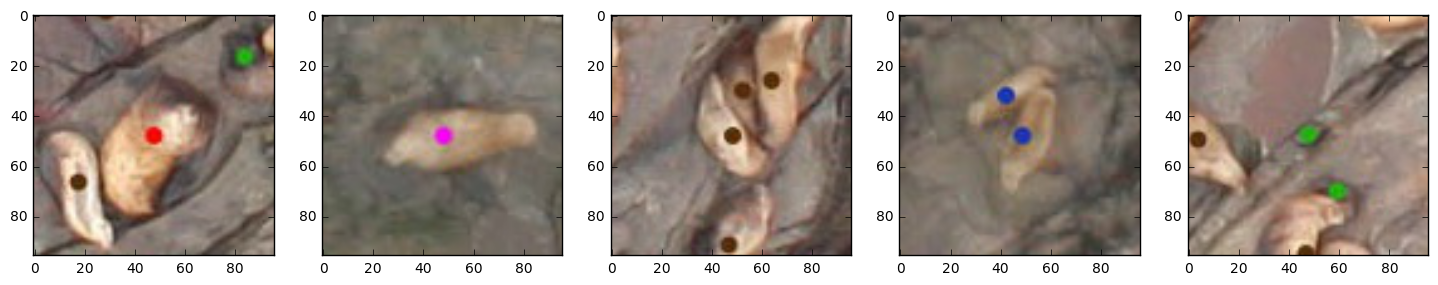

(96, 96, 3)


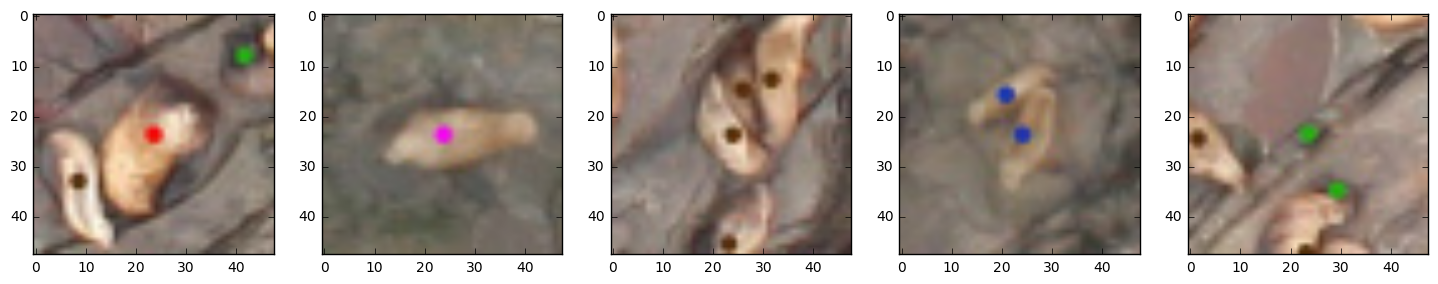

(48, 48, 3)


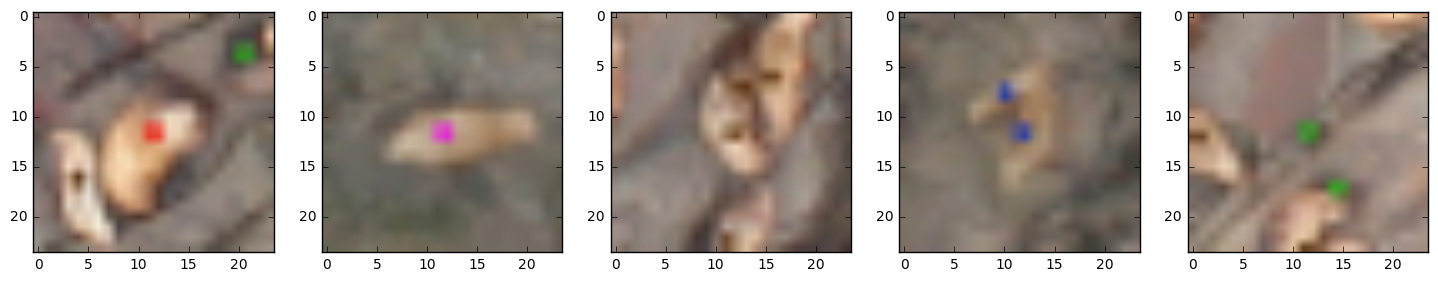

(24, 24, 3)


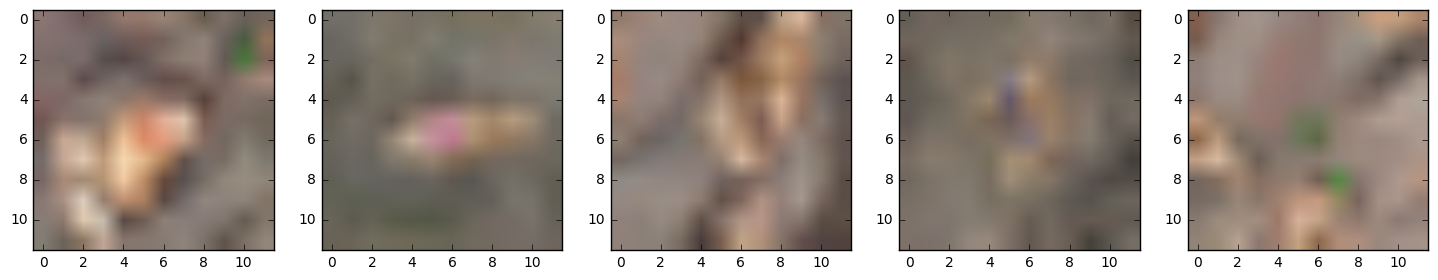

(12, 12, 3)


In [13]:
def resize_training_images():
    t = time.time()    
    print ('Resizing: Test/*.jpg')    
    fnames = glob.glob('./input/Test.*.jpg')    
    
    count = 0
    for fname in fnames:        
        count += 1
        if count % 100 == 0: print ('Working Test Image:',count)
        fname = fname[14:] 
        img_1 = mpimg.imread('./input/Test/'+fname)
        
        # compress and resize images in multiples of 448 x 448 to feed Yolo
        #x, y = int(img_1.shape[1]*0.5), int(img_1.shape[0]*0.5)    
        x, y = 6 * 448, 4 * 448
        
        img_1 = cv2.resize(img_1, (x,y))
        mpimg.imsave('./input_resize/Test/'+fname,img_1)

    print ('\nTime for resizing Test Images:', np.round(time.time() - t, 4),'\n')
    return None    

if (1): hf.show_pic_resize() 
if (0): resize_training_images()

## Preprocess Data: 2nd Phase: Extract Training Data from Training Images

In [14]:
def save_train_pics(train_img):
    
    # compare numbers of colors found from blob detection with true values
    def check_colors(fname):
        color_true, color_found, color_diff = list(df.loc[fname]), [], []
        for i in range(len(df_blob.loc[fname])-1):
            color_found.append(len(df_blob.loc[fname][i]))
            color_diff.append(color_true[i] - color_found[i])    
        return color_true, color_found, color_diff
    
    t = time.time()
    X_train, y_train = [], []
    
    # option to save colors with different sizes
    color_size = {'red':96,'magenta':96,'brown':96,'blue':96,'green':96}
    colors = ['red','magenta','brown','blue','green']
    
    # counter to index filenames
    counter = 0
    for fname in range(train_img[0],train_img[1]): # [0,947]
        
        # skipping training images with color differences from true values
        color_true, color_found, color_diff = check_colors(fname)
        if color_true != color_found:
            #print (fname, color_true, color_found, color_diff)
            continue

        img_1 = mpimg.imread('./input/Train/' + str(fname) + '.jpg')
        img_2 = mpimg.imread('./input/TrainDotted/' + str(fname) + '.jpg')

        for color in colors:
            crop = int(color_size[color]/2)
        
            for blob in df_blob.loc[fname][color]:
                y, x = blob[0], blob[1]
                
                range_y = range(crop, img_1.shape[0]-crop)
                range_x = range(crop, img_1.shape[1]-crop)
                
                if y in range_y and x in range_x: 
                    img_train_1 = img_1[y-crop:y+crop,x-crop:x+crop,:]
                    img_train_2 = img_2[y-crop:y+crop,x-crop:x+crop,:]
            
                    counter += 1
                    #print (fname, counter, img_train_1.shape, y, x)
                    mpimg.imsave('./input/X_Train/'+ str(counter) + '.jpg', img_train_1)
                    mpimg.imsave('./input/X_TrainDotted/'+ str(counter) + '.jpg', img_train_2)
                    X_train.append(counter)
                    y_train.append(color)

                    # getting random negative images
                    rand_shift = 200
                    y = y + np.random.randint(-rand_shift,rand_shift)
                    x = x + np.random.randint(-rand_shift,rand_shift)
            
                    range_y = range(crop, img_1.shape[0]-crop)
                    range_x = range(crop, img_1.shape[1]-crop)
                
                    if y in range_y and x in range_x:                    
                        img_train_1 = img_1[y-crop:y+crop,x-crop:x+crop,:]
                        img_train_2 = img_2[y-crop:y+crop,x-crop:x+crop,:]
                
                        counter += 1
                        mpimg.imsave('./input/X_Train/'+ str(counter) + '.jpg', img_train_1)
                        mpimg.imsave('./input/X_TrainDotted/'+ str(counter) + '.jpg', img_train_2)   
                        X_train.append(counter)
                        y_train.append('random')
                #if counter == 150: break

    df_img = pd.DataFrame()
    df_img['fname'] = X_train
    df_img['labels'] = y_train
                
    print ('\nTime for saving training images:', np.round(time.time() - t, 4))
    print ('Number of Training Image:',len(df_img))
    return df_img
    
if (1): 
    train_img = (41,51) # (0,947) 
    df_img = save_train_pics(train_img)
    pickle.dump(df_img,open('df_img.p','wb'))

df_img = pickle.load(open('df_img.p','rb'))


Time for saving training images: 19.0282
Number of Training Image: 2228


## Model Training: Stratified Random Sampling

In [15]:
def get_samples(df_img, colors):
    ''' randomly sample training data ==> we will expand with data augmentation '''
    
    num_colors = df_img['labels'].value_counts()
    balance_color, color_list = [], []
    
    print ('Numbers of samples in each Class:')
    for color in colors: 
        print (color,num_colors[color])
        balance_color.append(num_colors[color])
                             
    select = np.min(balance_color)
    
    print ('\nBalancing dataset (selecting):')                             
    for color in colors: print (color,select)
    
    red = df_img[df_img['labels'] == 'red']
    magenta = df_img[df_img['labels'] == 'magenta']
    brown = df_img[df_img['labels'] == 'brown']
    blue = df_img[df_img['labels'] == 'blue']
    green = df_img[df_img['labels'] == 'green']
    random = df_img[df_img['labels'] == 'random']

    # randomly select samples from each class
    if 'red' in colors:
        red = red.sample(n = select)
        color_list.append(red)
    if 'magenta' in colors:
        magenta = magenta.sample(n = select)
        color_list.append(magenta)
    if 'brown' in colors:
        brown = brown.sample(n = select)
        color_list.append(brown)
    if 'blue' in colors:
        blue = blue.sample(n = select)
        color_list.append(blue)
    if 'green' in colors: 
        green = green.sample(n = select)
        color_list.append(green)
    if 'random' in colors: 
        random = random.sample(n = select)
        color_list.append(random)

    df_train = pd.concat(color_list, ignore_index=True)
    num_colors = df_train['labels'].value_counts()
    return df_train

## Model Training: Augmenting Dataset

Numbers of samples in each Class:
red 63
random 1113

Balancing dataset (selecting):
red 63
random 63

X_train shape: (1000, 64, 64, 3)
y_train shape: (1000, 2)

Time for loading training images: 0.1821

Showing augmented data transformations:


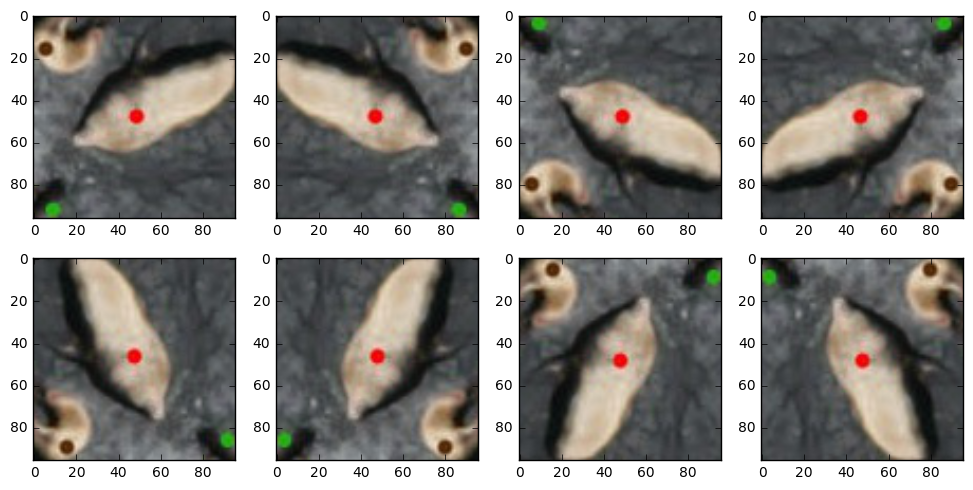

In [16]:
def get_train_data(pic_size, colors):
    t = time.time()
    df_train = get_samples(df_img, colors)
    images, category = [], []

    for i in range(1,len(df_train)):
        fname = df_train.loc[i]['fname']
        label = df_train.loc[i]['labels']
        img_1 = mpimg.imread('./input/X_Train/' + str(fname) + '.jpg')    
        if np.shape(img_1) != (pic_size[0], pic_size[1], 3): img_1 = cv2.resize(img_1, pic_size)            
        category.append(label)
        images.append(img_1)
        
        augment = True
        if augment:
            img_2 = np.fliplr(img_1)
            img_3 = np.flipud(img_1)
            img_4 = np.flipud(img_2)
            img_5 = np.rot90(img_1)
            img_6 = np.fliplr(img_5)
            img_7 = np.flipud(img_5)
            img_8 = np.flipud(img_6)
    
            for i in range(2,9): category.append(label)
            images.append(img_2)
            images.append(img_3)
            images.append(img_4)
            images.append(img_5)
            images.append(img_6)
            images.append(img_7)
            images.append(img_8)
    
    X_train = np.array(images)
    y_train = np.array(category)

    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    y_train = np_utils.to_categorical(encoded_Y)

    print ()
    print ('X_train shape:',X_train.shape)
    print ('y_train shape:',y_train.shape)
    print ('\nTime for loading training images:', np.round(time.time() - t, 4))
    return X_train, y_train

if (1):
    pic_size = (64,64)
    colors = ['red','random']
    X_train, y_train = get_train_data(pic_size, colors)
    hf.show_augmented_data()

## Model Training: Augmenting Dataset (additional possibilities)

Numbers of samples in each Class:
red 63
random 1113

Balancing dataset (selecting):
red 63
random 63

X_train shape: (1000, 64, 64, 3)
y_train shape: (1000, 2)

Time for loading training images: 0.1736


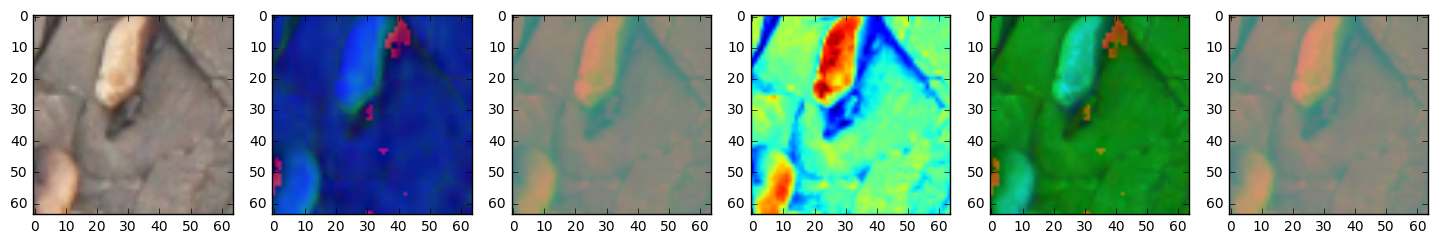

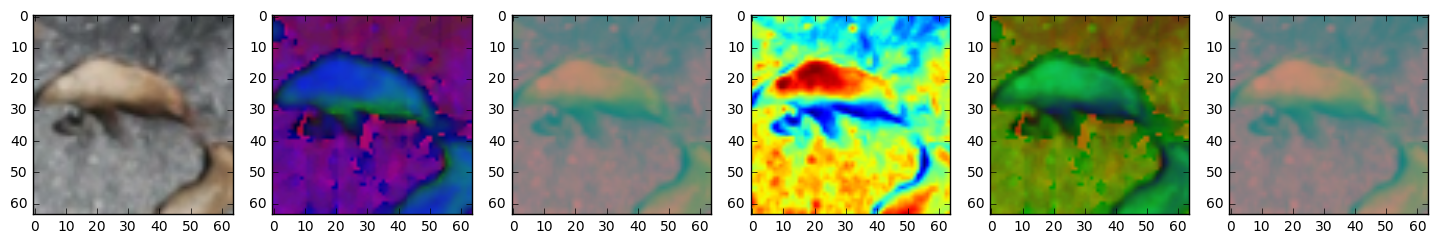

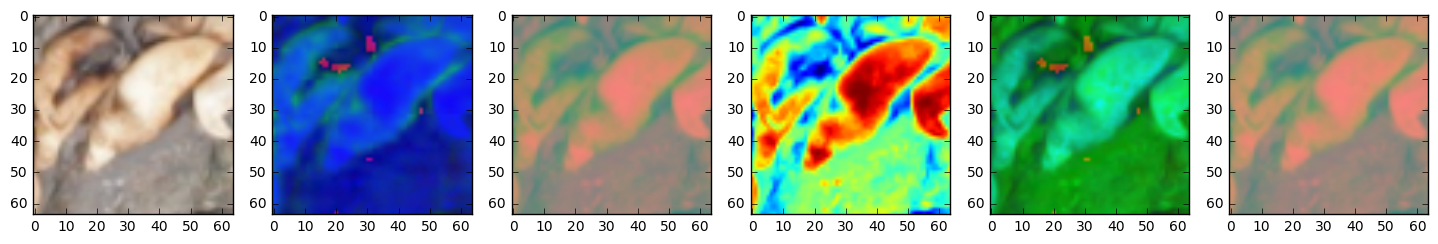

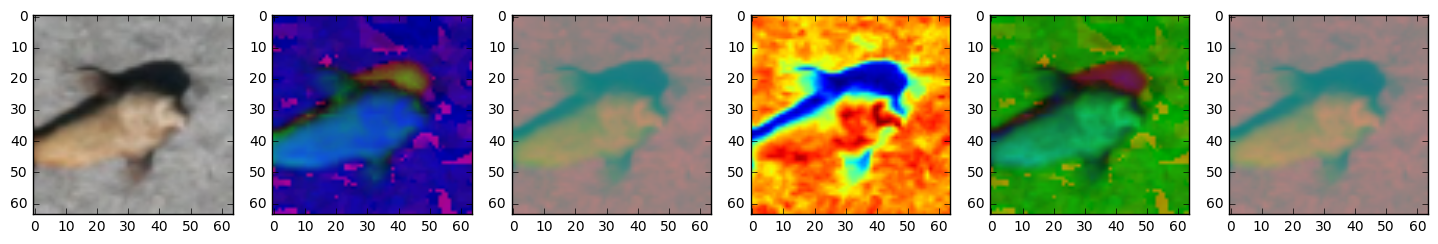

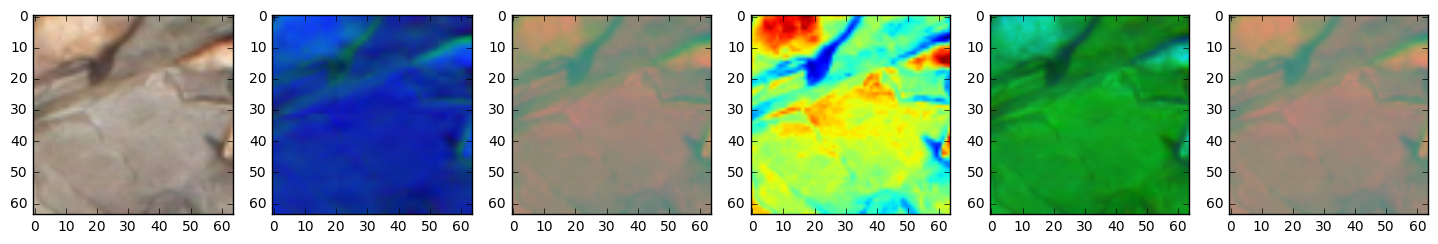

In [17]:
pic_size = (64,64)
colors = ['red','random']
X_train, y_train = get_train_data(pic_size, colors)

for i in range(5):
    idx = np.random.randint(0,len(X_train))
    img_1 = np.copy(X_train[idx])
    HSV = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
    YUV = cv2.cvtColor(img_1, cv2.COLOR_RGB2YUV)
    GRY = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
    HLS = cv2.cvtColor(img_1, cv2.COLOR_RGB2HLS)
    YCR = cv2.cvtColor(img_1, cv2.COLOR_RGB2YCrCb)
    
    plt.figure(figsize=(18,6))    
    plt.subplot(1,6,1)
    plt.imshow(img_1)
    plt.subplot(1,6,2)
    plt.imshow(HSV)
    plt.subplot(1,6,3)
    plt.imshow(YUV)
    plt.subplot(1,6,4)
    plt.imshow(GRY)
    plt.subplot(1,6,5)
    plt.imshow(HLS)
    plt.subplot(1,6,6)
    plt.imshow(YCR)
    plt.show()

## Method #1: Sliding Windows with NVIDIA Model Architecture

### Note: This is proof of concept only. Darknet will be implemented for counting Sea Lions

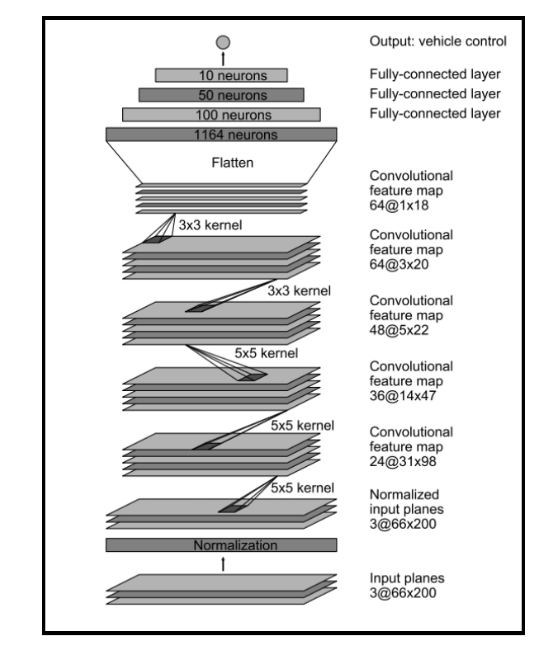

In [18]:
if (1): hf.show_nvidia_model()

In [19]:
def get_model(input_shape, classes):
    model = Sequential()
    #model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=()) # (0,255) --> (-1,1)
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
    model.add(Convolution2D(24, (5, 5), padding='valid', strides=(2, 2), activation='elu'))  
    model.add(Convolution2D(36, (5, 5), padding='valid', strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), padding='valid', strides=(2, 2), activation='elu'))
    #model.add(Convolution2D(64, (3, 3), padding='valid', strides=(1, 1), activation='elu'))
    #model.add(Convolution2D(64, (3, 3), padding='valid', strides=(1, 1), activation='elu')) 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(classes, activation='softmax'))
    return model

def histogram_equalize(img):
    r, g, b = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((red, green, blue))

def preprocess_data(X_train, y_train):
    X = []
    
    for i in range(len(X_train)):
        ### We can resize OR crop images OR both!! ###
        img_1 = histogram_equalize(np.copy(X_train[i]))   
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2HLS)
        X.append(img_1)
    
    X_train = np.array(X)
    return X_train, y_train

def run_model(pic_size, colors, X_train, y_train):
    t = time.time()
    X_train, y_train = get_train_data(pic_size, colors)
    X_train, y_train = preprocess_data(X_train, y_train)
    model = get_model(input_shape = (pic_size[0], pic_size[1], 3), classes = len(y_train[0])) 
    t = time.time()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.20, shuffle=True, epochs=5, verbose=1)
    hf.plot_loss(history)
    print ('\nTime for Training Model:', np.round(time.time() - t, 4))

Numbers of samples in each Class:
red 63
random 1113

Balancing dataset (selecting):
red 63
random 63

X_train shape: (1000, 64, 64, 3)
y_train shape: (1000, 2)

Time for loading training images: 0.1616
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 2s - loss: 0.3302 - categorical_accuracy: 0.8738 - val_loss: 0.0341 - val_categorical_accuracy: 1.0000
Epoch 2/5
800/800 [==============================] - 0s - loss: 0.1676 - categorical_accuracy: 0.9288 - val_loss: 0.4979 - val_categorical_accuracy: 0.7950
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.0845 - categorical_accuracy: 0.9713 - val_loss: 0.0305 - val_categorical_accuracy: 0.9950
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.0268 - categorical_accuracy: 0.9925 - val_loss: 0.1540 - val_categorical_accuracy: 0.9450
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.0139 - categorical_accuracy: 0.9962 - val_loss: 0.2744 - val_

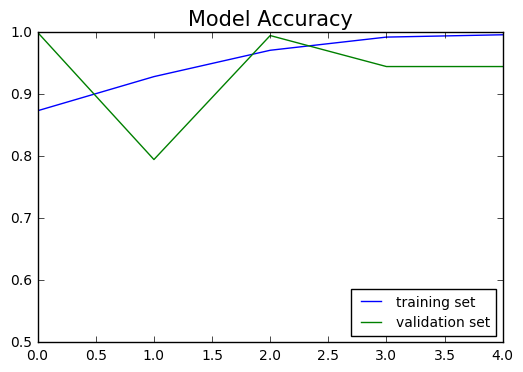


Time for Training Model: 6.9439


In [20]:
pic_size = (64,64)
colors = ['red','random']
run_model(pic_size, colors, X_train, y_train)

Numbers of samples in each Class:
magenta 29
random 1113

Balancing dataset (selecting):
magenta 29
random 29

X_train shape: (456, 64, 64, 3)
y_train shape: (456, 2)

Time for loading training images: 0.0846
Train on 364 samples, validate on 92 samples
Epoch 1/5
364/364 [==============================] - 0s - loss: 0.3545 - categorical_accuracy: 0.8187 - val_loss: 0.4536 - val_categorical_accuracy: 0.8261
Epoch 2/5
364/364 [==============================] - 0s - loss: 0.1671 - categorical_accuracy: 0.9478 - val_loss: 0.3519 - val_categorical_accuracy: 0.9130
Epoch 3/5
364/364 [==============================] - 0s - loss: 0.1115 - categorical_accuracy: 0.9670 - val_loss: 0.7724 - val_categorical_accuracy: 0.8043
Epoch 4/5
364/364 [==============================] - 0s - loss: 0.0808 - categorical_accuracy: 0.9725 - val_loss: 0.1246 - val_categorical_accuracy: 0.9348
Epoch 5/5
364/364 [==============================] - 0s - loss: 0.1166 - categorical_accuracy: 0.9560 - val_loss: 0.1812 -

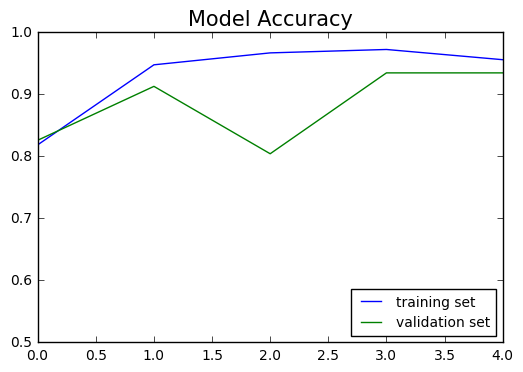


Time for Training Model: 3.7757


In [21]:
pic_size = (64,64)
colors = ['magenta','random']
run_model(pic_size, colors, X_train, y_train)

Numbers of samples in each Class:
brown 628
random 1113

Balancing dataset (selecting):
brown 628
random 628

X_train shape: (10040, 64, 64, 3)
y_train shape: (10040, 2)

Time for loading training images: 1.5115
Train on 8032 samples, validate on 2008 samples
Epoch 1/5
8032/8032 [==============================] - 9s - loss: 0.2887 - categorical_accuracy: 0.8845 - val_loss: 0.3010 - val_categorical_accuracy: 0.8680
Epoch 2/5
8032/8032 [==============================] - 9s - loss: 0.2362 - categorical_accuracy: 0.9054 - val_loss: 0.6156 - val_categorical_accuracy: 0.7301
Epoch 3/5
8032/8032 [==============================] - 9s - loss: 0.2008 - categorical_accuracy: 0.9216 - val_loss: 0.5215 - val_categorical_accuracy: 0.7913
Epoch 4/5
8032/8032 [==============================] - 9s - loss: 0.1548 - categorical_accuracy: 0.9405 - val_loss: 0.4948 - val_categorical_accuracy: 0.8197
Epoch 5/5
8032/8032 [==============================] - 9s - loss: 0.1180 - categorical_accuracy: 0.9539 - va

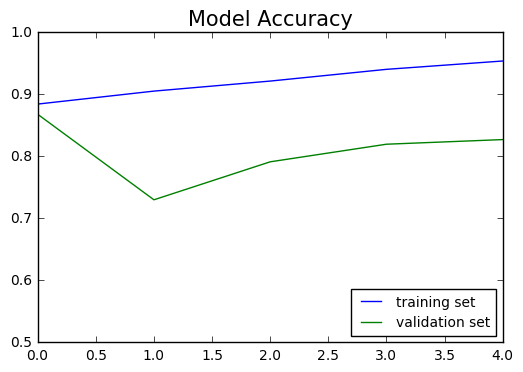


Time for Training Model: 49.075


In [22]:
pic_size = (64,64)
colors = ['brown','random']
run_model(pic_size, colors, X_train, y_train)

Numbers of samples in each Class:
blue 147
random 1113

Balancing dataset (selecting):
blue 147
random 147

X_train shape: (2344, 64, 64, 3)
y_train shape: (2344, 2)

Time for loading training images: 0.6459
Train on 1875 samples, validate on 469 samples
Epoch 1/5
1875/1875 [==============================] - 2s - loss: 0.3883 - categorical_accuracy: 0.8347 - val_loss: 0.5831 - val_categorical_accuracy: 0.6972
Epoch 2/5
1875/1875 [==============================] - 2s - loss: 0.2573 - categorical_accuracy: 0.9024 - val_loss: 0.4452 - val_categorical_accuracy: 0.7804
Epoch 3/5
1875/1875 [==============================] - 2s - loss: 0.1873 - categorical_accuracy: 0.9349 - val_loss: 0.4309 - val_categorical_accuracy: 0.8380
Epoch 4/5
1875/1875 [==============================] - 2s - loss: 0.1420 - categorical_accuracy: 0.9493 - val_loss: 0.6404 - val_categorical_accuracy: 0.7910
Epoch 5/5
1875/1875 [==============================] - 2s - loss: 0.0977 - categorical_accuracy: 0.9648 - val_los

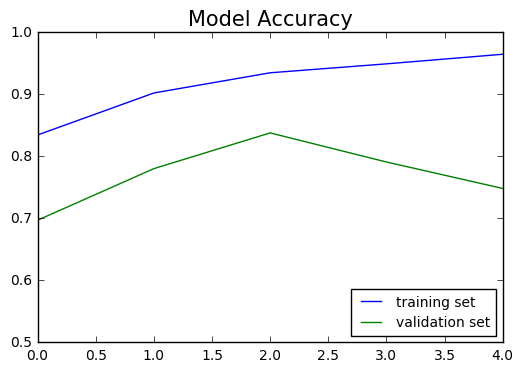


Time for Training Model: 15.3744


In [23]:
pic_size = (64,64)
colors = ['blue','random']
run_model(pic_size, colors, X_train, y_train)

Numbers of samples in each Class:
green 248
random 1113

Balancing dataset (selecting):
green 248
random 248

X_train shape: (3960, 64, 64, 3)
y_train shape: (3960, 2)

Time for loading training images: 1.6796
Train on 3168 samples, validate on 792 samples
Epoch 1/5
3168/3168 [==============================] - 5s - loss: 0.3645 - categorical_accuracy: 0.8409 - val_loss: 0.2841 - val_categorical_accuracy: 0.8914
Epoch 2/5
3168/3168 [==============================] - 4s - loss: 0.2865 - categorical_accuracy: 0.8835 - val_loss: 0.4487 - val_categorical_accuracy: 0.8182
Epoch 3/5
3168/3168 [==============================] - 4s - loss: 0.2303 - categorical_accuracy: 0.9138 - val_loss: 0.3662 - val_categorical_accuracy: 0.8497
Epoch 4/5
3168/3168 [==============================] - 4s - loss: 0.1777 - categorical_accuracy: 0.9315 - val_loss: 0.5356 - val_categorical_accuracy: 0.8043
Epoch 5/5
3168/3168 [==============================] - 4s - loss: 0.1245 - categorical_accuracy: 0.9527 - val_l

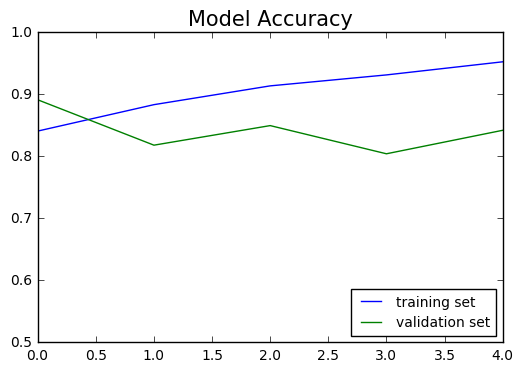


Time for Training Model: 23.8702


In [24]:
pic_size = (64,64)
colors = ['green','random']
run_model(pic_size, colors, X_train, y_train)

## Method #2: Darknet-19 Model Architecture (YOLO v2)

### (next phase of project)

## Discussion

**The Stratified Random Sampling section is currently written to only select the number of samples given by the smallest class being considered (which keeps the classes balanced). The data augmentation expands the dataset by 8X, so the SRS section should be rewritten to allow for inputing the desired number of training samples (which can have an upper limit of 8X the number of the smallest class).**

**One particularly interesting way to further augment the dataset would be with Random Cropping to offset training images after above transformations. Random Cropping towards the corners of the extracted image would create 4X more pics for training. Transformations (8X) and Random Cropping (4X) would expand the dataset by 32X.**

**There are 83,677 sea lions in the 1000 aerial photographs provided for training. The smallest class (magenta, subadult male) only has 4345 instances. Using full data augmentation (32X), this would allow for 139,040 training images in every class to be created and used for a balanced dataset. The present model has only been trained on sea lions from 10 aerial photographs.**

**Darknet-19 does about 75 fps (448 x 488) on Titan X. Resizing each Test Image (2688 x 1792) would reduce file size by about 70% and enable partitioning of each image into 24 x (448 x 448) tiles to feed the Darknet. 18,000 Test Images x 24 Tiles x 75 fps should take about 1.6 hours.**